In [154]:
import os
import pandas as pd
from kernels.wrapper import MODELS, KernelModelWrapper
from dataset.ipc2023_learning_domain_info import IPC2023_LEARNING_DOMAINS, get_test_ipc2023_learning_instance_files, get_best_bound
from itertools import product
from IPython.display import display, HTML
from util.scrape_log import scrape_search_log
from util.visualise import *

In [155]:
_PAPER_DIR=str(Path.home())+"/papers/manuscripts/24-icaps-kernels"
# _PAPER_DIR=str(Path.home())+"/papers/manuscripts/23-genplan-kernels"

In [156]:
pd.options.display.float_format = "{:.1f}".format

In [157]:
_LOG_DIR = "logs/test_ipc2023"
_DIFFICULTIES = ["easy", "medium", "hard"]
_MODELS = [
  # "linear-regression",
  "muninn", 
  "goose", 
  "ridge", 
  "lasso", 
  "linear-svr", 
  "quadratic-svr", 
  "cubic-svr",
  "rbf-svr", 
]

In [158]:
def get_data(domain):
  data = {
  }

  test_files = get_test_ipc2023_learning_instance_files()

  for model in _MODELS:
    d = {
      "solved": [],
      "expanded": [],
      "cost": [],
      "first_h": [],
      "quality": [],
      "c_opt": [],
      "difficulty": [],
    }

    for difficulty in _DIFFICULTIES:
      for df, pf in test_files[domain]:
        if not difficulty in pf:
          continue
        pf_name = os.path.basename(pf).replace(".pddl", "")

        if model=="muninn":
          stats = {
            "first_h": -1,
            "solved": 0,
            "time": -1,
            "cost": -1,
            "expanded": -1,
            "evaluated": -1,
          }

          log_file = f"logs/logs_muninn/{domain}_{difficulty}_{pf_name}_domain-knowledge-{domain}.dk.log"
        
          if not os.path.exists(log_file):
            continue

          """
          [1] Subplan: 10, Heuristic: 9.998 -> goal, Expanded: 22, Generated: 86 (260 ms)
          Writing file "plan.1" (10 actions)
          Planned for 0 minutes and 0 seconds
          """

          for line in open(log_file, 'r').readlines():
            if "[1]" in line and stats['solved'] == 0:
              toks = line.replace(",", "").replace("(", "").split()
              stats["first_h"] = float(toks[4])
            if "Writing file" in line:
              toks = line.replace(",", "").replace("(", "").split()
              stats["cost"] = int(toks[-2])
              stats["solved"] = 1
        elif model=="goose":
          log_file = f"{_LOG_DIR}/{domain}_{difficulty}_{pf_name}_-scratch-sv11-dc6693-trained_models_gnn-ipc2023-learning-{domain}-0.log"
        
          if not os.path.exists(log_file):
            continue

          stats = scrape_search_log(log_file)
        else:
          log_file = f"{_LOG_DIR}/{domain}_{difficulty}_{pf_name}_-scratch-sv11-dc6693-trained_models_kernel-{model}_llg2_ipc2023-learning-{domain}_wl_1_0.joblib.log"
        
          if not os.path.exists(log_file):
            continue

          stats = scrape_search_log(log_file)


        for k in d:
          if k in stats:
            d[k].append(stats[k])
        
        c = stats["cost"]
        c_opt = get_best_bound(domain, difficulty, pf_name)
        quality = c_opt / c
        quality = max(quality, 0)
        quality = min(quality, 1)
        d["quality"].append(quality)
        d["c_opt"].append(c_opt)
        d["difficulty"].append(difficulty)
        
    data[model] = d

  return data

In [159]:
def get_metrics_df(data):
  d = {
    "config": [],
    "quality": [],
    "solved": [],
    "tried": [],
    "e_quality": [],
    "e_solved": [],
    "e_tried": [],
    "m_quality": [],
    "m_solved": [],
    "m_tried": [],
    "h_quality": [],
    "h_solved": [],
    "h_tried": [],
  }
  for config in _MODELS:
    d["config"].append(config)
    d["quality"].append(sum(data[config]["quality"]))
    d["solved"].append(sum(data[config]["solved"]))
    d["tried"].append(len(data[config]["solved"]))
    for difficulty in _DIFFICULTIES:
      quality = 0
      solved = 0
      tried = 0
      if config=="muninn":
        print(difficulty, len(data[config]["solved"]))
      for i, prob_solved in enumerate(data[config]["solved"]):
        if data[config]["difficulty"][i] == difficulty:
          quality += data[config]["quality"][i]
          solved += prob_solved
          tried += 1
      d[f"{difficulty[0]}_quality"].append(quality)
      d[f"{difficulty[0]}_solved"].append(solved)
      d[f"{difficulty[0]}_tried"].append(tried)
  return pd.DataFrame(d)

In [160]:
def get_table_df():
  d = {
    "domain": [],
  }
  for config in _MODELS:
    d[config] = []

  sum_scores = {config: 0 for config in _MODELS}

  for domain in IPC2023_LEARNING_DOMAINS:
    data = get_data(domain)
    d["domain"].append(domain)

    for config in _MODELS:
      score = sum(data[config]["quality"])
      d[config].append(score)
      sum_scores[config] += score
  

  d["domain"].append("sum")
  for config in _MODELS:
    d[config].append(sum_scores[config])

  return pd.DataFrame(d)

In [161]:
scores_df = get_table_df()
scores = scores_df.to_numpy()
scores = scores[:,1:]
display(scores_df)

,domain,muninn,goose,ridge,lasso,linear-svr,quadratic-svr,cubic-svr,rbf-svr
0,blocksworld,39.0,50.5,4.9,11.5,18.9,14.1,10.4,15.7
1,childsnack,11.0,9.6,20.7,8.8,17.1,10.0,10.0,13.0
2,ferry,46.0,60.7,36.3,60.6,75.6,71.5,57.1,34.6
3,floortile,0.0,0.0,0.9,2.9,1.9,0.0,0.0,0.0
4,miconic,30.0,73.2,28.3,30.0,28.7,28.5,28.9,28.5
5,rovers,14.2,23.3,9.7,16.0,16.3,17.1,17.5,14.2
6,satellite,18.0,5.8,11.3,7.5,5.3,14.0,13.4,8.4
7,sokoban,25.2,25.8,34.8,23.0,35.0,30.5,28.0,27.9
8,spanner,32.0,30.9,24.9,30.0,25.9,25.9,26.3,25.9
9,transport,17.0,21.0,12.2,32.2,17.4,30.2,28.1,28.6


In [162]:
for domain in IPC2023_LEARNING_DOMAINS:
  print(domain)
  data = get_data(domain)
  display(get_metrics_df(data))

blocksworld
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,muninn,39.0,39,90,30.0,30,30,9.0,9,30,0,0,30
1,goose,50.5,51,70,29.5,30,30,21.0,21,30,0,0,10
2,ridge,4.9,8,60,4.9,8,30,0.0,0,30,0,0,0
3,lasso,11.5,21,60,11.5,21,30,0.0,0,30,0,0,0
4,linear-svr,18.9,29,60,18.3,28,30,0.7,1,30,0,0,0
5,quadratic-svr,14.1,23,60,14.1,23,30,0.0,0,30,0,0,0
6,cubic-svr,10.4,18,60,10.4,18,30,0.0,0,30,0,0,0
7,rbf-svr,15.7,24,60,15.7,24,30,0.0,0,30,0,0,0


childsnack
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,muninn,11.0,11,90,11.0,11,30,0,0,30,0,0,30
1,goose,9.6,10,45,9.6,10,22,0,0,0,0,0,23
2,ridge,20.7,28,60,20.7,28,30,0,0,30,0,0,0
3,lasso,8.8,9,60,8.8,9,30,0,0,30,0,0,0
4,linear-svr,17.1,18,60,17.1,18,30,0,0,30,0,0,0
5,quadratic-svr,10.0,10,60,10.0,10,30,0,0,30,0,0,0
6,cubic-svr,10.0,10,60,10.0,10,30,0,0,30,0,0,0
7,rbf-svr,13.0,13,60,13.0,13,30,0,0,30,0,0,0


ferry
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,muninn,46.0,46,90,30.0,30,30,16.0,16,30,0,0,30
1,goose,60.7,61,74,29.7,30,30,30.0,30,30,1,1,14
2,ridge,36.3,41,90,26.9,30,30,9.3,11,30,0,0,30
3,lasso,60.6,61,90,29.6,30,30,30.0,30,30,1,1,30
4,linear-svr,75.6,76,90,29.6,30,30,30.0,30,30,16,16,30
5,quadratic-svr,71.5,72,90,29.5,30,30,30.0,30,30,12,12,30
6,cubic-svr,57.1,58,90,29.1,30,30,26.9,27,30,1,1,30
7,rbf-svr,34.6,35,90,29.6,30,30,5.0,5,30,0,0,30


floortile
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,muninn,0.0,0,90,0.0,0,30,0,0,30,0,0,30
1,goose,0.0,0,0,0.0,0,0,0,0,0,0,0,0
2,ridge,0.9,1,30,0.9,1,30,0,0,0,0,0,0
3,lasso,2.9,3,30,2.9,3,30,0,0,0,0,0,0
4,linear-svr,1.9,2,30,1.9,2,30,0,0,0,0,0,0
5,quadratic-svr,0.0,0,30,0.0,0,30,0,0,0,0,0,0
6,cubic-svr,0.0,0,30,0.0,0,30,0,0,0,0,0,0
7,rbf-svr,0.0,0,30,0.0,0,30,0,0,0,0,0,0


miconic
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,muninn,30.0,30,90,30.0,30,30,0,0,30,0,0,30
1,goose,73.2,74,74,29.2,30,30,30,30,30,14,14,14
2,ridge,28.3,30,60,28.3,30,30,0,0,30,0,0,0
3,lasso,30.0,30,60,30.0,30,30,0,0,30,0,0,0
4,linear-svr,28.7,30,60,28.7,30,30,0,0,30,0,0,0
5,quadratic-svr,28.5,30,60,28.5,30,30,0,0,30,0,0,0
6,cubic-svr,28.9,30,60,28.9,30,30,0,0,30,0,0,0
7,rbf-svr,28.5,30,60,28.5,30,30,0,0,30,0,0,0


rovers
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,muninn,14.2,15,90,14.2,15,30,0,0,30,0,0,30
1,goose,23.3,28,42,23.3,28,28,0,0,0,0,0,14
2,ridge,9.7,13,60,9.7,13,30,0,0,30,0,0,0
3,lasso,16.0,19,60,16.0,19,30,0,0,30,0,0,0
4,linear-svr,16.3,22,60,16.3,22,30,0,0,30,0,0,0
5,quadratic-svr,17.1,21,60,17.1,21,30,0,0,30,0,0,0
6,cubic-svr,17.5,22,60,17.5,22,30,0,0,30,0,0,0
7,rbf-svr,14.2,18,60,14.2,18,30,0,0,30,0,0,0


satellite
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,muninn,18.0,18,90,16.0,16,30,2,2,30,0,0,30
1,goose,5.8,11,13,5.8,11,11,0,0,2,0,0,0
2,ridge,11.3,23,60,11.3,23,30,0,0,30,0,0,0
3,lasso,7.5,12,60,7.5,12,30,0,0,30,0,0,0
4,linear-svr,5.3,15,60,5.3,15,30,0,0,30,0,0,0
5,quadratic-svr,14.0,24,60,14.0,24,30,0,0,30,0,0,0
6,cubic-svr,13.4,24,60,13.4,24,30,0,0,30,0,0,0
7,rbf-svr,8.4,16,60,8.4,16,30,0,0,30,0,0,0


sokoban
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,muninn,25.2,27,90,25.2,27,30,0.0,0,30,0,0,30
1,goose,25.8,29,33,24.8,28,28,1.0,1,1,0,0,4
2,ridge,34.8,38,90,26.9,30,30,8.0,8,30,0,0,30
3,lasso,23.0,23,90,23.0,23,30,0.0,0,30,0,0,30
4,linear-svr,35.0,38,90,27.0,30,30,8.0,8,30,0,0,30
5,quadratic-svr,30.5,33,90,26.7,29,30,3.7,4,30,0,0,30
6,cubic-svr,28.0,31,90,27.0,30,30,1.0,1,30,0,0,30
7,rbf-svr,27.9,30,90,27.9,30,30,0.0,0,30,0,0,30


spanner
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,muninn,32.0,32,90,30.0,30,30,2.0,2,30,0,0,30
1,goose,30.9,35,35,25.9,30,30,5.0,5,5,0,0,0
2,ridge,24.9,29,60,24.9,29,30,0.0,0,30,0,0,0
3,lasso,30.0,30,60,30.0,30,30,0.0,0,30,0,0,0
4,linear-svr,25.9,30,60,25.9,30,30,0.0,0,30,0,0,0
5,quadratic-svr,25.9,30,60,25.9,30,30,0.0,0,30,0,0,0
6,cubic-svr,26.3,30,60,26.3,30,30,0.0,0,30,0,0,0
7,rbf-svr,25.9,30,60,25.9,30,30,0.0,0,30,0,0,0


transport
easy 90
medium 90
hard 90


,config,quality,solved,tried,e_quality,e_solved,e_tried,m_quality,m_solved,m_tried,h_quality,h_solved,h_tried
0,muninn,17.0,17,90,17.0,17,30,0.0,0,30,0,0,30
1,goose,21.0,25,49,20.4,24,24,0.7,1,1,0,0,24
2,ridge,12.2,21,60,10.5,18,30,1.6,3,30,0,0,0
3,lasso,32.2,33,60,29.2,30,30,3.0,3,30,0,0,0
4,linear-svr,17.4,26,60,15.7,23,30,1.7,3,30,0,0,0
5,quadratic-svr,30.2,32,60,28.4,30,30,1.8,2,30,0,0,0
6,cubic-svr,28.1,30,60,28.1,30,30,0.0,0,30,0,0,0
7,rbf-svr,28.6,31,60,27.6,30,30,1.0,1,30,0,0,0


In [163]:
""" scores.tex """
ret  = r"\begin{tabular}{c c c c c c c c c} \toprule Domain "
for model in _MODELS:
  ret += f"& \\header{{\{model.replace('-', '')}}} "
ret += r"\\ \midrule" + '\n'

for domain, scores_domain in zip(IPC2023_LEARNING_DOMAINS, scores):
  ret += domain
  best_score = max(scores_domain)
  for score in scores_domain:
    if score==best_score:
      ret += f" & \\textbf{{{score:.1f}}}"
    else:
      ret += f" & {score:.1f}"
  ret += "\\\\ \n"

ret += "\midrule  sum"
best_score = max(scores[-1])
for score in scores[-1]:
    if score==best_score:
      ret += f" & \\textbf{{{score:.1f}}}"
    else:
      ret += f" & {score:.1f}"
ret += "\\\\"

ret += r"\bottomrule\end{tabular}"

f = open(f"{_PAPER_DIR}/figures/scores.tex", 'w')
f.write(ret)
f.close()

In [164]:
""" coverage2.tex """

scores_df = get_table_df()
scores = scores_df.to_numpy()
scores = scores[:,1:]

ret  = r"\begin{tabular}{c c c c c c c c c} \toprule Domain "
for model in _MODELS:
    ret += f"& \\header{{\{model.replace('-', '')}}} "
ret += r"\\ \midrule" + '\n'

all_solved = {
  "easy": np.zeros(len(_MODELS)).astype(int),
  "medium": np.zeros(len(_MODELS)).astype(int),
  "hard": np.zeros(len(_MODELS)).astype(int),
  "all": np.zeros(len(_MODELS)).astype(int),
}

for domain, scores_domain in zip(IPC2023_LEARNING_DOMAINS, scores):
  ret += f"\\multirow{{2}}{{*}}{{{domain}}}"
  data = (get_metrics_df(get_data(domain)).to_numpy())
  solved = {
    "easy": data[:,5].T,
    "medium": data[:,8].T,
    "hard": data[:,11].T,
  }

  for i in range(len(solved["easy"])):
    chunks = []
    for difficulty in solved:

      scores_domain = solved[difficulty]
      if i==0:
        all_solved[difficulty] += scores_domain.astype(int)
      best_score = max(scores_domain)
      score = solved[difficulty][i]
      if score == 0:
        chunks.append("-")
      elif score==best_score:
        chunks.append(f"\\textbf{{{score}}}")
      else:
        chunks.append(f"{score}")

    chunk = "/".join(chunks)
    ret += f" & {chunk}"
  ret += "\\\\ \n"

  solved = {
    "all": data[:,2].T,
  }

  for i in range(len(solved["all"])):
    chunks = []
    for difficulty in solved:

      scores_domain = solved[difficulty]
      if i==0:
        all_solved[difficulty] += scores_domain.astype(int)
      best_score = max(scores_domain)
      score = solved[difficulty][i]
      if score == 0:
        chunks.append("-")
      elif score==best_score:
        chunks.append(f"\\textbf{{{score}}}")
      else:
        chunks.append(f"{score}")

    chunk = "/".join(chunks)
    ret += f" & {chunk}"
  
  if domain==IPC2023_LEARNING_DOMAINS[-1]:
    ret += "\\\\ \midrule \n"
  else:
    ret += "\\\\ \cmidrule(lr){2-9} \n"

ret += f"\\multirow{{2}}{{*}}{{sum}}"
for i in range(len(all_solved["all"])):
    chunks = []
    for difficulty in ["easy", "medium", "hard"]:

        scores_domain = all_solved[difficulty]
        best_score = max(scores_domain)
        score = all_solved[difficulty][i]
        print(score, best_score)
        if score == 0:
          chunks.append("-")
        elif score==best_score:
          chunks.append(f"\\textbf{{{score}}}")
        else:
          chunks.append(f"{score}")

    chunk = "/".join(chunks)
    ret += f" & {chunk}"

ret += r" \\ "

for i in range(len(all_solved["all"])):
    chunks = []
    for difficulty in ["all"]:

        scores_domain = all_solved[difficulty]
        best_score = max(scores_domain)
        score = all_solved[difficulty][i]
        print(score, best_score)
        if score == 0:
          chunks.append("-")
        elif score==best_score:
          chunks.append(f"\\textbf{{{score}}}")
        else:
          chunks.append(f"{score}")

    chunk = "/".join(chunks)
    ret += f" & {chunk}"

ret += r" \\ \bottomrule\end{tabular}"

f = open(f"{_PAPER_DIR}/figures/coverage2.tex", 'w')
f.write(ret)
f.close()

In [ ]:
os.makedirs("plots", exist_ok=True)
for domain in IPC2023_LEARNING_DOMAINS:
  try:
    data = get_data(domain)

    max_val = 0

    for config in CONFIGS:
      cs = np.array(data[config]["cost"])
      c_opts = np.array(data[config]["c_opt"])
      index = np.where(cs != -1)
      cs = cs[index]
      c_opts = c_opts[index]
      plt.scatter(c_opts, cs, label="_".join(config))
      max_val = max([max_val, max(cs), max(c_opts)])
    
    plt.title(domain)
    plt.plot([1, max_val], [1, max_val], alpha=0.5, linestyle="dotted", c='k')
    plt.ylabel("C")
    plt.xlabel("C* (not necessarily optimal)")
    plt.legend()
    # plt.show()
    plt.savefig(f"plots/{_REP}_cost_ipc2023-learning-{domain}.png")
  except:
    pass
  plt.clf()
print("c vs c* saved")

c vs c* saved


<Figure size 640x480 with 0 Axes>

KeyError: ('ridge', '1')

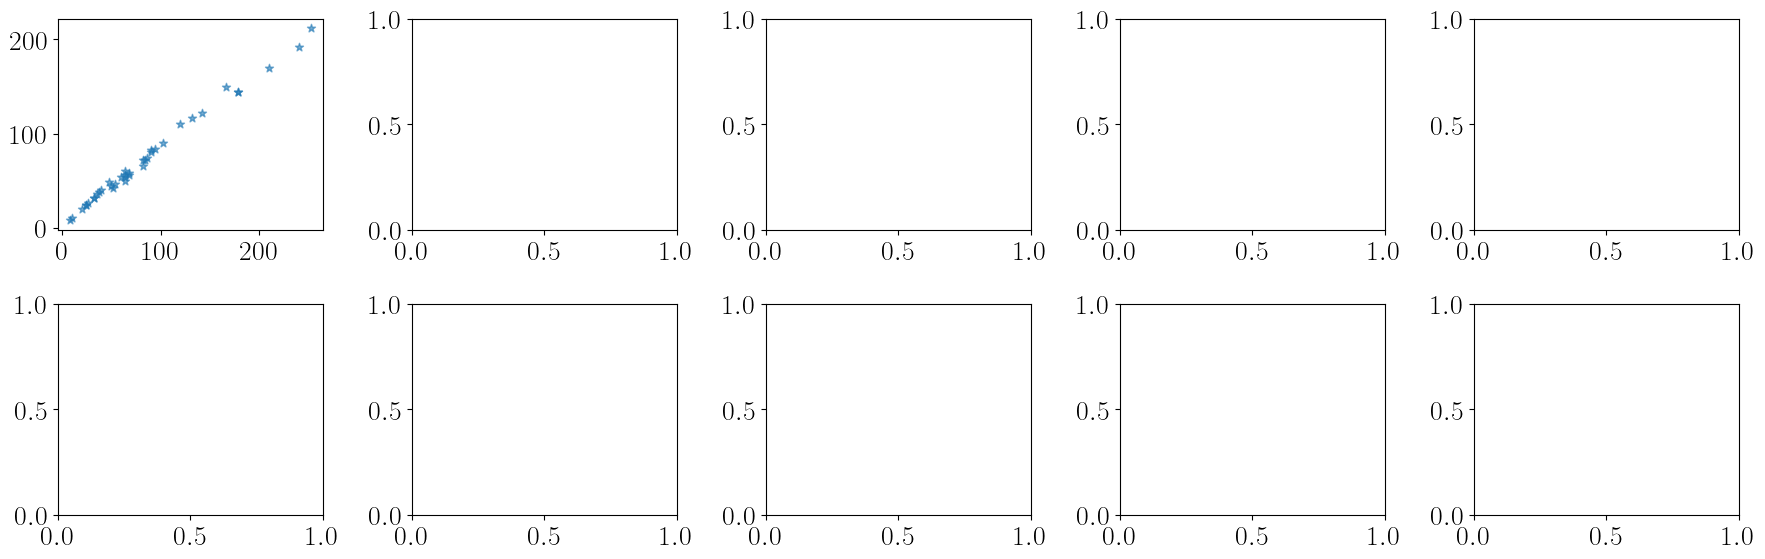

In [ ]:
plt.rcParams.update({
  "text.usetex": True,
  "font.size": 20,
})

fig, axs = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=False, figsize=(18, 6))
fig.tight_layout()

for k, domain in enumerate(IPC2023_LEARNING_DOMAINS):
  i = k // 5
  j = k % 5
  data = get_data(domain)
  max_val = 0

  for config in ["muninn"] + CONFIGS:
    cs = np.array(data[config]["cost"])
    c_opts = np.array(data[config]["c_opt"])
    index = np.where(cs != -1)
    cs = cs[index]
    c_opts = c_opts[index]
    label = "Muninn" if config == "muninn" else config[0]
    if config=="muninn":
      marker='*'
    elif "svr" in config[0]:
      marker='x'
    else:
      marker='o'
    axs[i,j].scatter(c_opts, cs, label=label, alpha=0.6, marker=marker)
    try:
      max_val = max([max_val, max(cs), max(c_opts)])
    except:
      pass
  
  axs[i,j].plot([1, max_val], [1, max_val], alpha=0.5, linestyle="dotted", c='k')
  axs[i,j].set_title(domain)

plt.legend(loc=(1.1, 0.5))
plt.savefig(f"{_PAPER_DIR}/figures/cost.pdf", bbox_inches="tight")
plt.show()

In [ ]:
os.makedirs("plots", exist_ok=True)
for domain in IPC2023_LEARNING_DOMAINS:
  try:
    data = get_data(domain)

    max_val = 0

    my_dict = {}

    fig, ax = plt.subplots()

    for config in CONFIGS:
      expanded = np.array(data[config]["expanded"])
      # index = np.where(expanded != -1)
      expanded = expanded[index]
      my_dict["_".join(config)] = expanded
    
    plt.yscale("log")
    plt.title(domain)
    ax.boxplot(my_dict.values())
    ax.set_xticklabels(my_dict.keys())
    # plt.ylim(bottom=1)
    # plt.show()
    plt.savefig(f"plots/{_REP}_expanded_ipc2023-learning-{domain}.png")
  except:
    pass
  plt.clf()
print("expansions saved")

logs/test_ipc2023/blocksworld_hard_p01_-scratch-sv11-dc6693-trained_models_kernel-ridge_llg2_ipc2023-learning-blocksworld_wl_1_0.joblib.log
logs/test_ipc2023/blocksworld_hard_p02_-scratch-sv11-dc6693-trained_models_kernel-ridge_llg2_ipc2023-learning-blocksworld_wl_1_0.joblib.log
logs/test_ipc2023/blocksworld_hard_p03_-scratch-sv11-dc6693-trained_models_kernel-ridge_llg2_ipc2023-learning-blocksworld_wl_1_0.joblib.log
logs/test_ipc2023/blocksworld_hard_p04_-scratch-sv11-dc6693-trained_models_kernel-ridge_llg2_ipc2023-learning-blocksworld_wl_1_0.joblib.log
logs/test_ipc2023/blocksworld_hard_p05_-scratch-sv11-dc6693-trained_models_kernel-ridge_llg2_ipc2023-learning-blocksworld_wl_1_0.joblib.log
logs/test_ipc2023/blocksworld_hard_p06_-scratch-sv11-dc6693-trained_models_kernel-ridge_llg2_ipc2023-learning-blocksworld_wl_1_0.joblib.log
logs/test_ipc2023/blocksworld_hard_p07_-scratch-sv11-dc6693-trained_models_kernel-ridge_llg2_ipc2023-learning-blocksworld_wl_1_0.joblib.log
logs/test_ipc2023/bl

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>